In [75]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### _Load the data and split into Train and Test sets_

In [76]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [77]:
#Inspect the data
print(f"X_train shape:{X_train.shape}")
print(f"Y_train shape:{Y_train.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"Y_test shape:{Y_test.shape}")
print(f"Number of training examples/images:{X_train.shape[0]}")
print(f"Number of testing examples/images:{X_test.shape[0]}")

X_train shape:(50000, 32, 32, 3)
Y_train shape:(50000, 1)
X_test shape:(10000, 32, 32, 3)
Y_test shape:(10000, 1)
Number of training examples/images:50000
Number of testing examples/images:10000


#### _Single image visualisation_

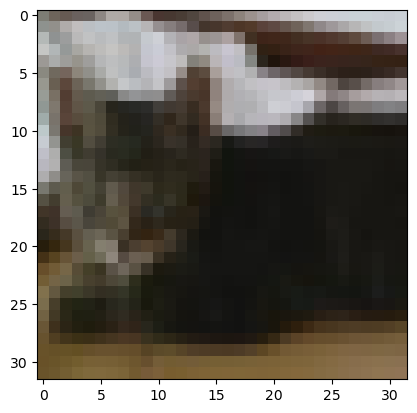

Class:cat


In [78]:
# Visualize the images in the training dataset
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
index = 9
plt.imshow(X_train[index])
plt.show()
print(f"Class:{class_names[Y_train[index][0]]}")

#### _Multiple image visualisation_

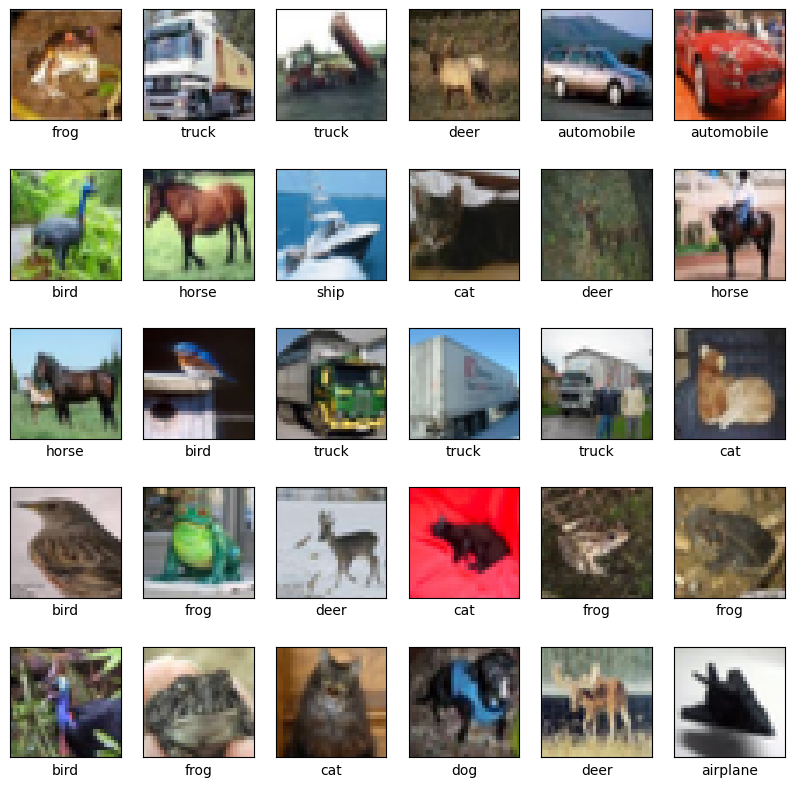

In [79]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(visible=False)
    plt.imshow(X_train[i])
    plt.xlabel(class_names[Y_train[i][0]])
plt.show()

### _Data Preprocessing_

In [80]:
# Normalize the images
X_train = X_train/255.0
X_test = X_test/255.0

#Convert labels to one hot encoded vectors
Y_train = tf.keras.utils.to_categorical(Y_train,num_classes=10)
Y_test = tf.keras.utils.to_categorical(Y_test,num_classes=10)

In [81]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                            horizontal_flip=True, fill_mode='nearest')
datagen.fit(X_train)

In [82]:
# EarlyStopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### _Binary Classification Model with Sequential API_

In [83]:
# Convert the labels to a binary classification problem (Airplane vs Not Airplane)
Y_train_binary = np.where(Y_train[:,0]==1, 1,0) # class 0 for Airplane
Y_test_binary = np.where(Y_test[:,0]==1, 1,0)

# Build the Sequential model
binary_model = tf.keras.Sequential([
    tfl.Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3)),
    tfl.ReLU(),
    tfl.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'), 
    tfl.Conv2D(64, kernel_size=(3,3)),
    tfl.ReLU(),
    tfl.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    tfl.Conv2D(128, kernel_size=(3,3)),
    tfl.ReLU(),
    tfl.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    tfl.Flatten(),
    tfl.Dense(128, activation='relu'), 
    tfl.Dropout(0.5),
    tfl.Dense(1, activation='sigmoid')
])

In [84]:
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
binary_history = binary_model.fit(datagen.flow(X_train, Y_train_binary, batch_size=64), epochs=50, 
                                  validation_data=(X_test, Y_test_binary), callbacks=[early_stopping])

Epoch 1/50


2024-08-31 22:07:30.509716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


778/782 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.9016

2024-08-31 22:07:40.243196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 11s 13ms/step - loss: 0.2695 - accuracy: 0.9017 - val_loss: 0.2211 - val_accuracy: 0.9164
Epoch 2/50
782/782 [==============================] - 10s 13ms/step - loss: 0.2340 - accuracy: 0.9093 - val_loss: 0.2099 - val_accuracy: 0.9180
Epoch 3/50
782/782 [==============================] - 10s 13ms/step - loss: 0.2173 - accuracy: 0.9155 - val_loss: 0.2038 - val_accuracy: 0.9261
Epoch 4/50
782/782 [==============================] - 10s 13ms/step - loss: 0.2075 - accuracy: 0.9208 - val_loss: 0.1674 - val_accuracy: 0.9333
Epoch 5/50
782/782 [==============================] - 10s 13ms/step - loss: 0.2014 - accuracy: 0.9225 - val_loss: 0.1644 - val_accuracy: 0.9389
Epoch 6/50
782/782 [==============================] - 10s 13ms/step - loss: 0.1948 - accuracy: 0.9253 - val_loss: 0.1624 - val_accuracy: 0.9382
Epoch 7/50
782/782 [==============================] - 10s 13ms/step - loss: 0.1904 - accuracy: 0.9264 - val_loss: 0.1554 - val_accuracy: 0.9417
Epo

### _Multiclass Classification Model with Functional API_

In [103]:
# Build the model
input_img = tf.keras.Input(shape=(32,32,3))

# Convolutional layers with BatchNormalization, ReLu activation and MaxPooling
Z1 = tfl.Conv2D(filters=32, kernel_size=(3,3), padding='same')(input_img)
BN1 = tfl.BatchNormalization()(Z1)
A1 = tfl.ReLU()(BN1)
P1 = tfl.MaxPooling2D(pool_size=(2,2))(A1)

Z2 = tfl.Conv2D(filters=64, kernel_size=(3,3), padding='same')(P1)
BN2 = tfl.BatchNormalization()(Z2)
A2 = tfl.ReLU()(BN2)
P2 = tfl.MaxPooling2D(pool_size=(2,2))(A2)

Z3 = tfl.Conv2D(filters=128, kernel_size=(3,3), padding='same')(P2)
BN3 = tfl.BatchNormalization()(Z3)
A3 = tfl.ReLU()(BN3)
P3 = tfl.MaxPooling2D(pool_size=(2,2))(A3)

Z4 = tfl.Conv2D(filters=256, kernel_size=(3,3), padding='same')(P3)
BN4 = tfl.BatchNormalization()(Z4)
A4 = tfl.ReLU()(BN4)
P4 = tfl.MaxPooling2D(pool_size=(2,2))(A4)


# Flatten and Dense layer
F = tfl.Flatten()(P4)
FC1 = tfl.Dense(units=128, activation='relu')(F)
D = tfl.Dropout(0.4)(FC1)

FC2 = tfl.Dense(units=64, activation='relu')(D)
D2 = tfl.Dropout(0.4)(FC2)

# Output layer
output_layer = tfl.Dense(units=10, activation='softmax')(D2)

multiclass_model = tf.keras.Model(inputs=input_img, outputs=output_layer)

In [104]:
multiclass_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
multiclass_model_history = multiclass_model.fit(datagen.flow(X_train, Y_train, batch_size=64), epochs=50,
                                                validation_data=(X_test, Y_test), callbacks=[early_stopping])

Epoch 1/50


2024-09-02 12:26:48.377766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


781/782 [============================>.] - ETA: 0s - loss: 6.5539 - accuracy: 0.2024

2024-09-02 12:27:14.557875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 30s 37ms/step - loss: 6.5496 - accuracy: 0.2024 - val_loss: 5.2325 - val_accuracy: 0.2322
Epoch 2/50
782/782 [==============================] - 27s 35ms/step - loss: 2.9468 - accuracy: 0.2853 - val_loss: 2.0446 - val_accuracy: 0.4088
Epoch 3/50
782/782 [==============================] - 27s 34ms/step - loss: 2.2277 - accuracy: 0.3443 - val_loss: 1.5374 - val_accuracy: 0.4642
Epoch 4/50
782/782 [==============================] - 27s 34ms/step - loss: 1.9451 - accuracy: 0.3837 - val_loss: 2.1198 - val_accuracy: 0.3849
Epoch 5/50
782/782 [==============================] - 27s 34ms/step - loss: 1.7635 - accuracy: 0.4223 - val_loss: 1.4335 - val_accuracy: 0.4754
Epoch 6/50
782/782 [==============================] - 27s 34ms/step - loss: 1.6347 - accuracy: 0.4542 - val_loss: 1.9478 - val_accuracy: 0.4204
Epoch 7/50
782/782 [==============================] - 27s 35ms/step - loss: 1.5474 - accuracy: 0.4760 - val_loss: 1.6948 - val_accuracy: 0.4890
Epo

### _Model evaluation_

In [105]:
# Evaluate the binary classification model
binary_test_loss, binary_test_acc = binary_model.evaluate(X_test,Y_test_binary)
print(f"Binary classification test loss: {binary_test_loss:.4f}")
print(f"Binary classification test accuracy: {binary_test_acc:.4f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.1353 - accuracy: 0.9509
Binary classification test loss: 0.1353
Binary classification test accuracy: 0.9509


In [106]:
# Evaluate the multiclass classification model
multiclass_test_loss, multiclass_test_acc = multiclass_model.evaluate(X_test, Y_test)
print(f"Multiclass classification test loss: {multiclass_test_loss:.4f}")
print(f"Multiclass classification test accuracy: {multiclass_test_acc:.4f}")

313/313 [==============================] - 4s 12ms/step - loss: 0.9428 - accuracy: 0.6987
Multiclass classification test loss: 0.9428
Multiclass classification test accuracy: 0.6987


### _Plot accuracy_

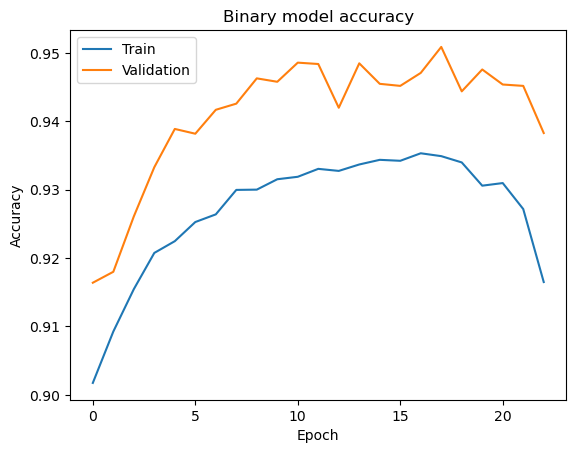

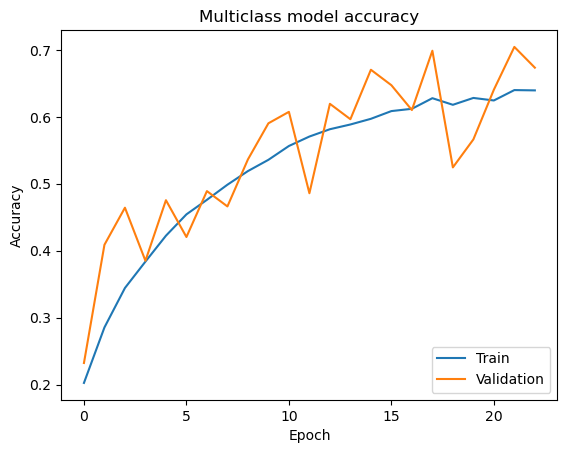

In [107]:
# Plot training and validation accuracy
# Binary class model
plt.plot(binary_history.history["accuracy"])
plt.plot(binary_history.history["val_accuracy"])
plt.title("Binary model accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

# Multiclass model
plt.plot(multiclass_model_history.history['accuracy'])
plt.plot(multiclass_model_history.history['val_accuracy'])
plt.title('Multiclass model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

### _Save and Load_

In [109]:
binary_model.save('/Users/subhamgogoi/Coding/Jupyter/Projects/CIFAR10-CNN-Classifier/binary-model.h5')
multiclass_model.save('/Users/subhamgogoi/Coding/Jupyter/Projects/CIFAR10-CNN-Classifier/multiclass-model.h5')